# Análises COVID-19

#### Vamos analisar as séries temporais sobre a contaminação do vírus COVID-19 pelo mundo.

In [1]:
!pip install pyramid-arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyramid-arima-0.8.1.tar.gz (515 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pyramid-arima
  Running setup.py clean for pyramid-arima
Failed to build pyramid-arima
  error: subprocess-exited-with-error
  
  × Running setup.py install for pyramid-arima did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for pyramid-arima ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> pyramid-arima

note: This is an issue with the package mentio

In [2]:
!pip install neuralprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")
sns.set()

### Importar dos dados. 
##### - É importante já dizer no comando `pd.read_csv` quais são as colunas que serão "parseadas" como datas. O pandas possui métodos robustos para trabalhar com esse tipo de informação.

In [5]:
endereco = '/content/covid_19_data.csv'
df = pd.read_csv(endereco, parse_dates=['ObservationDate', 'Last Update'])
df

SNo ObservationDate Province/State  Country/Region  \
0          1      2020-01-22          Anhui  Mainland China   
1          2      2020-01-22        Beijing  Mainland China   
2          3      2020-01-22      Chongqing  Mainland China   
3          4      2020-01-22         Fujian  Mainland China   
4          5      2020-01-22          Gansu  Mainland China   
...      ...             ...            ...             ...   
26708  26709      2020-05-19        Wyoming              US   
26709  26710      2020-05-19       Xinjiang  Mainland China   
26710  26711      2020-05-19          Yukon          Canada   
26711  26712      2020-05-19         Yunnan  Mainland China   
26712  26713      2020-05-19       Zhejiang  Mainland China   

              Last Update  Confirmed  Deaths  Recovered  
0     2020-01-22 17:00:00        1.0     0.0        0.0  
1     2020-01-22 17:00:00       14.0     0.0        0.0  
2     2020-01-22 17:00:00        6.0     0.0        0.0  
3     2020-01-22 17:00:00        1.0     0.0        0.0  
4     2020-01-22 17:00:00        0.0     0.0        0.0  
...                   ...        ...     ...        ...  
26708 2020-05-20 02:32:19      776.0    10.0        0.0  
26709 2020-05-20 02:32:19       76.0     3.0       73.0  
26710 2020-05-20 02:32:19       11.0     0.0       11.0  
26711 2020-05-20 02:32:19      185.0     2.0      183.0  
26712 2020-05-20 02:32:19     1268.0     1.0     1267.0  

[26713 rows x 8 columns]

### Tipos das variáveis para verificar as colunas.

In [6]:
df.dtypes

SNo                         int64
ObservationDate    datetime64[ns]
Province/State             object
Country/Region             object
Last Update        datetime64[ns]
Confirmed                 float64
Deaths                    float64
Recovered                 float64
dtype: object

### Nomes de colunas não devem ter letras maiúsculas e nem caracteres especiais. Utilizando função com Regex para modificar.

In [7]:
import re
def corrige_colunas(col_name):
    return re.sub(r"[/| ]", "", col_name).lower()

In [8]:
df.columns = [corrige_colunas(col) for col in df.columns]

In [9]:
df.columns

Index(['sno', 'observationdate', 'provincestate', 'countryregion',
       'lastupdate', 'confirmed', 'deaths', 'recovered'],
      dtype='object')

In [10]:
df

sno observationdate provincestate   countryregion  \
0          1      2020-01-22         Anhui  Mainland China   
1          2      2020-01-22       Beijing  Mainland China   
2          3      2020-01-22     Chongqing  Mainland China   
3          4      2020-01-22        Fujian  Mainland China   
4          5      2020-01-22         Gansu  Mainland China   
...      ...             ...           ...             ...   
26708  26709      2020-05-19       Wyoming              US   
26709  26710      2020-05-19      Xinjiang  Mainland China   
26710  26711      2020-05-19         Yukon          Canada   
26711  26712      2020-05-19        Yunnan  Mainland China   
26712  26713      2020-05-19      Zhejiang  Mainland China   

               lastupdate  confirmed  deaths  recovered  
0     2020-01-22 17:00:00        1.0     0.0        0.0  
1     2020-01-22 17:00:00       14.0     0.0        0.0  
2     2020-01-22 17:00:00        6.0     0.0        0.0  
3     2020-01-22 17:00:00        1.0     0.0        0.0  
4     2020-01-22 17:00:00        0.0     0.0        0.0  
...                   ...        ...     ...        ...  
26708 2020-05-20 02:32:19      776.0    10.0        0.0  
26709 2020-05-20 02:32:19       76.0     3.0       73.0  
26710 2020-05-20 02:32:19       11.0     0.0       11.0  
26711 2020-05-20 02:32:19      185.0     2.0      183.0  
26712 2020-05-20 02:32:19     1268.0     1.0     1267.0  

[26713 rows x 8 columns]

### Análises

##### Vamos investigar as variáveis que temos à disposição. Sabemos que trata-se de séries temporais que estão divididas por estado. Para fazer qualquer análise, portanto, precisamos dividir os nossos dados esse "grão". 

##### Informações para o Brasil.

In [11]:
df.loc[df.countryregion == 'Brazil']

sno observationdate provincestate countryregion          lastupdate  \
82        83      2020-01-23           NaN        Brazil 2020-01-23 17:00:00   
2455    2456      2020-02-26           NaN        Brazil 2020-02-26 23:53:02   
2559    2560      2020-02-27           NaN        Brazil 2020-02-26 23:53:02   
2668    2669      2020-02-28           NaN        Brazil 2020-02-26 23:53:02   
2776    2777      2020-02-29           NaN        Brazil 2020-02-29 21:03:05   
...      ...             ...           ...           ...                 ...   
24850  24851      2020-05-15           NaN        Brazil 2020-05-16 02:32:19   
25227  25228      2020-05-16           NaN        Brazil 2020-05-17 02:32:32   
25604  25605      2020-05-17           NaN        Brazil 2020-05-18 02:32:21   
25981  25982      2020-05-18           NaN        Brazil 2020-05-19 02:32:18   
26358  26359      2020-05-19           NaN        Brazil 2020-05-20 02:32:19   

       confirmed   deaths  recovered  
82           0.0      0.0        0.0  
2455         1.0      0.0        0.0  
2559         1.0      0.0        0.0  
2668         1.0      0.0        0.0  
2776         2.0      0.0        0.0  
...          ...      ...        ...  
24850   220291.0  14962.0    84970.0  
25227   233511.0  15662.0    89672.0  
25604   241080.0  16118.0    94122.0  
25981   255368.0  16853.0   100459.0  
26358   271885.0  17983.0   106794.0  

[85 rows x 8 columns]

### Casos confirmados

##### No caso do Brasil, não há informação a nível de estado, apenas a nível do país. Analisar casos confirmados -- 



In [12]:
brasil = df.loc[(df.countryregion == 'Brazil') & (df.confirmed > 0)]

In [13]:
px.line?

In [14]:
px.line(brasil, 'observationdate', 'confirmed', 
        labels={'observationdate':'Data', 'confirmed':'Número de casos confirmados'},
       title='Casos confirmados no Brasil')

### Número de novos casos por dia

In [15]:
# função para fazer a contagem de novos casos
brasil['novoscasos'] = list(map(lambda x: 0 if (x==0) else brasil['confirmed'].iloc[x] - brasil['confirmed'].iloc[x-1],np.arange(brasil.shape[0])))

In [16]:
# Visualizando
px.line(brasil, x='observationdate', y='novoscasos', title='Novos casos por dia',
       labels={'observationdate': 'Data', 'novoscasos': 'Novos casos'})

O número de novos casos parece ser um excelente caso para modelagem. Será que conseguimos predizer quando o número de novos casos vai começar a cair?

### Mortes

In [17]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=brasil.observationdate, y=brasil.deaths, name='Mortes', mode='lines+markers',
              line=dict(color='red'))
)
#Edita o layout
fig.update_layout(title='Mortes por COVID-19 no Brasil',
                   xaxis_title='Data',
                   yaxis_title='Número de mortes')
fig.update_layout(width=1200, height=400)
fig.show()
#fig.write_html('mortes_covid_brasil.html')
#fig.write_image("/content/mortes_covid_brasil.png")

In [18]:
# from IPython.display import HTML
# with open('mortes_covid_brasil.html', 'r', encoding='utf-8') as f:
#     html_str = f.read()
# HTML(html_str)


#from IPython.display import Image
#Image(filename='/content/mortes_covid_brasil.png')


### Taxa de crescimento

Vamos calcular a taxa de crescimento do COVID desde o primeiro caso.

In [19]:
def taxa_crescimento(data, variable, data_inicio=None, data_fim=None):
    # Se data_inicio for None, define como a primeira data disponível no dataset
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    if data_fim == None:
        data_fim = data.observationdate.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)
    
    # Define os valores de presente e passado
    passado = data.loc[data.observationdate == data_inicio, variable].values[0]
    presente = data.loc[data.observationdate == data_fim, variable].values[0]
    
    # Define o número de pontos no tempo q vamos avaliar
    n = (data_fim - data_inicio).days
    
    # Calcula a taxa
    taxa = (presente/passado)**(1/n) - 1

    return taxa*100

In [20]:
cresc_medio = taxa_crescimento(brasil, 'confirmed')
print(f"O crescimento médio do COVID no Brasil no período avaliado foi de {cresc_medio.round(2)}%.")

O crescimento médio do COVID no Brasil no período avaliado foi de 16.27%.


Agora, vamos observar o comportamento da **taxa de crescimento no tempo**. Para isso, vamos definir uma função para calcular a taxa de crescimento diária.

In [21]:
def taxa_crescimento_diaria(data, variable, data_inicio=None):
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    data_fim = data.observationdate.max()
    n = (data_fim - data_inicio).days
    taxas = list(map(
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
        range(1,n+1)
    ))
    return np.array(taxas)*100

In [22]:
tx_dia = taxa_crescimento_diaria(brasil, 'confirmed')

In [23]:
tx_dia

array([  0.        ,   0.        , 100.        ,   0.        ,
         0.        ,   0.        , 100.        ,   0.        ,
       225.        ,   0.        ,  53.84615385,  25.        ,
        24.        ,  22.58064516,  36.84210526, 190.38461538,
         0.        ,   7.28476821,  23.45679012,  60.5       ,
        15.88785047,  66.93548387,  27.69726248,  28.75157629,
        51.4201763 ,  24.45019405,  16.78794179,  13.66266133,
        16.87548943,  14.47236181,  14.25226807,   9.01639344,
         7.58928571,  24.8525879 ,  19.57320273,  17.67115272,
        12.58080557,  14.39929329,   7.43243243,   9.26325247,
        15.40169394,  15.22017956,  11.88620903,   8.54521335,
         5.54537122,   7.06807546,   5.57858688,   7.81903542,
        12.10513815,   7.4329096 ,  10.70501233,   8.83557983,
         5.44492335,   5.4043566 ,   5.73350023,   6.21648599,
         9.35157462,   8.00823407,   9.77184834,   6.36504619,
         6.88748019,   8.58316283,   8.80726429,   9.41

In [24]:
primeiro_dia = brasil.observationdate.loc[brasil.confirmed > 0].min()
px.line(x=pd.date_range(primeiro_dia, brasil.observationdate.max())[1:],
        y=tx_dia, title='Taxa de crescimento de casos confirmados no Brasil',
       labels={'y':'Taxa de crescimento', 'x':'Data'})

### Predições

Construindo um modelo de séries temporais para prever novos casos. Antes analisamos a série temporal.

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

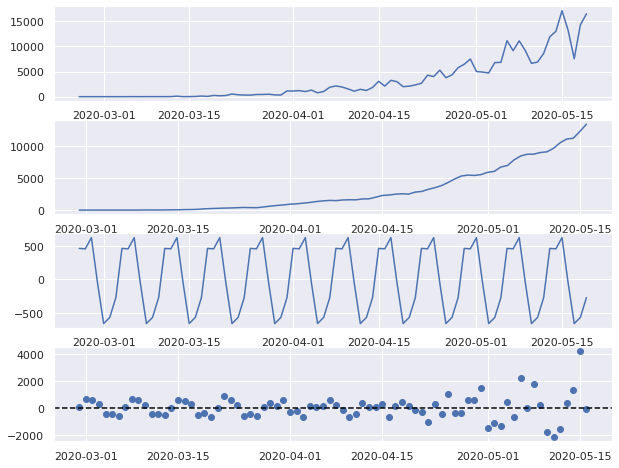

In [26]:
novoscasos = brasil.novoscasos
novoscasos.index = brasil.observationdate

res = seasonal_decompose(novoscasos)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(10,8))
ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.scatter(novoscasos.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

### Decompondo a série de confirmados



In [27]:
confirmados = brasil.confirmed
confirmados.index = brasil.observationdate

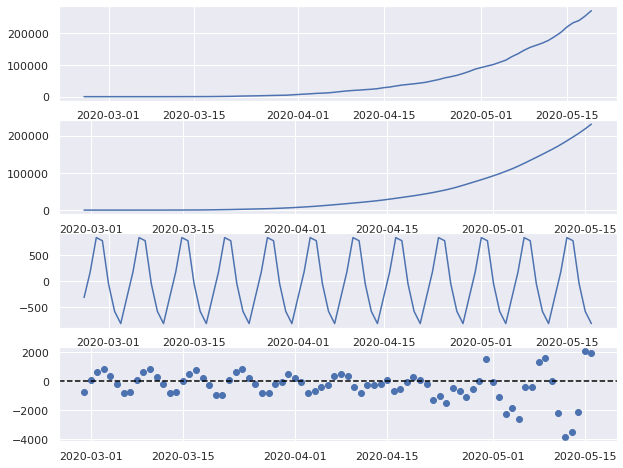

In [28]:
res2 = seasonal_decompose(confirmados)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(10,8))
ax1.plot(res2.observed)
ax2.plot(res2.trend)
ax3.plot(res2.seasonal)
ax4.scatter(confirmados.index, res2.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

### Predizendo o número de casos confirmados com um AUTO-ARIMA

In [32]:
import pmdarima as pm

In [33]:
modelo = pm.auto_arima(confirmados)

In [34]:
pd.date_range('2020-05-01', '2020-05-19')

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
               '2020-05-17', '2020-05-18', '2020-05-19'],
              dtype='datetime64[ns]', freq='D')

In [35]:
fig = go.Figure(go.Scatter(x=confirmados.index, y=confirmados, name='Observed'))

fig.add_trace(go.Scatter(x=confirmados.index, y = modelo.predict_in_sample(), name='Predicted'))

fig.add_trace(go.Scatter(x=pd.date_range('2020-05-20', '2020-06-05'), y=modelo.predict(15), name='Forecast'))

fig.update_layout(title='Previsão de casos confirmados para os próximos 15 dias',yaxis_title='Casos confirmados', xaxis_title='Data')
fig.show()

### Forecasting com Prophet

In [37]:
from neuralprophet import NeuralProphet

In [38]:
import os
if not os.path.exists("/content/lightning_logs"):
    os.makedirs("/content/lightning_logs")
else:
    os.path.exists("/content/lightning_logs")
    pass


In [39]:
# preparando os dados
train_df = confirmados.reset_index()[:-5]
test_df = confirmados.reset_index()[-5:]

# renomeia colunas
train_df = train_df.rename(columns={"observationdate":"ds","confirmed":"y"})
test_df = test_df.rename(columns={"observationdate":"ds","confirmed":"y"})

# define a capacidade máxima do modelo
pop = 211463256 #https://www.ibge.gov.br/apps/populacao/projecao/box_popclock.php

# cria o modelo
model = NeuralProphet(
    changepoints_range=0.9,
    n_changepoints=10,
    trend_reg=0.05,
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode="additive",
    impute_missing=True,
)

# treina o modelo
model.fit(train_df, freq="D", validation_df=test_df)

# faz a previsão
future = model.make_future_dataframe(
    df=test_df,
    periods=5,
    n_historic_predictions=len(train_df)
)
forecast = model.predict(future)


INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO:NP.config:Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.734% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.734% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 627
INFO:NP.confi

Finding best initial lr:   0%|          | 0/206 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 80.0% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 80.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 79 historic forecasts, reduced to 5.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 90.0% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 90.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 90.0% of the data.
INFO:NP.df_utils:Major frequenc

Predicting: 5it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


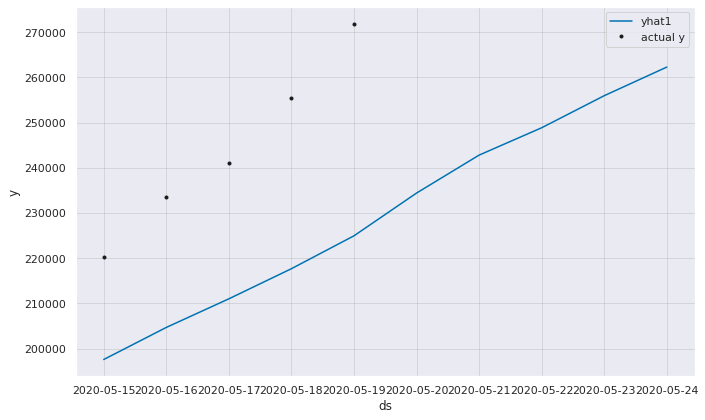

In [49]:
fig = forecasts_plot = model.plot(forecast)
fig.show()

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


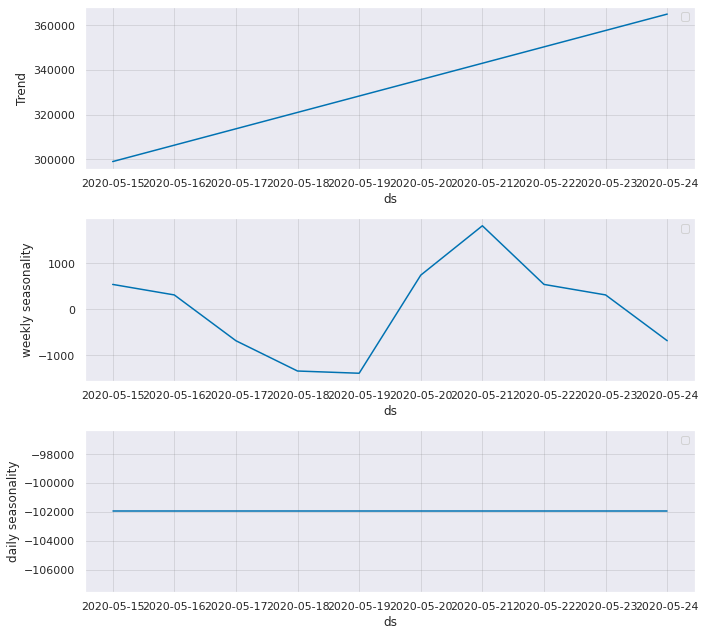

In [55]:
fig_comp = model.plot_components(forecast)
fig_comp.show()

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


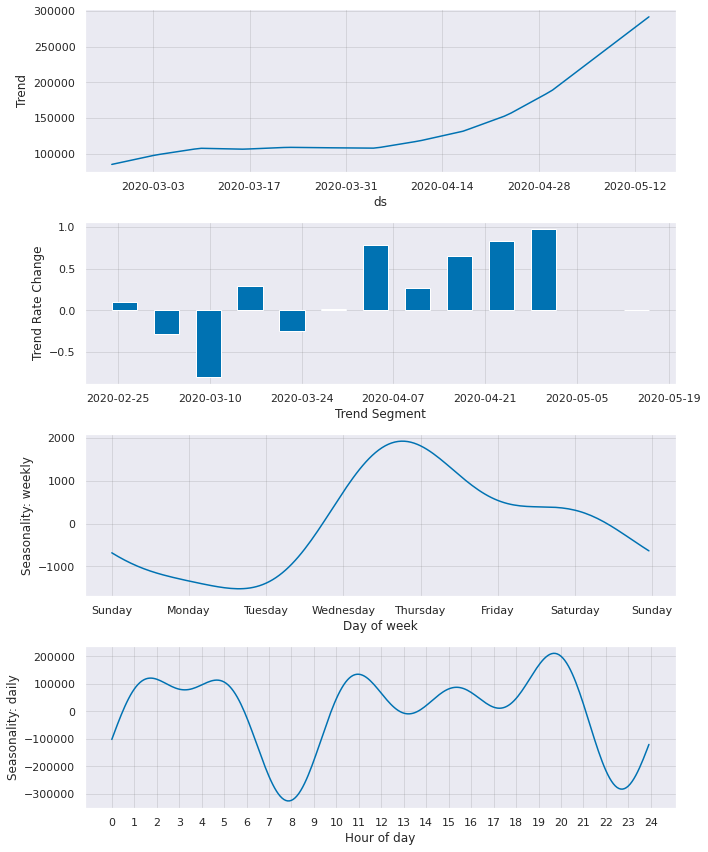

In [56]:
fig_param = model.plot_parameters()
fig_param.show()

É isso... feito com neural prophet

<!-- fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='Predição'))
fig.add_trace(go.Scatter(x=test.index, y=test, name='Observados - Teste'))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name='Observados - Treino'))
fig.update_layout(title='Predições de casos confirmados no Brasil')
fig.show() -->